In [2]:
import tensorflow as tf
import os
import keras.backend as K
DEFER_DELETE_SIZE=int(250 * 1e6) 
def create_tensorflow_session(visiblegpus):
    os.environ['CUDA_VISIBLE_DEVICES'] = str(visiblegpus)
    session_config = tf.ConfigProto()
    session_config.gpu_options.deferred_deletion_bytes = DEFER_DELETE_SIZE
    session_config.gpu_options.per_process_gpu_memory_fraction = 0.20
    session = tf.Session(config=session_config)
    K.set_session(session)
    return session
create_tensorflow_session(1)

/users/manyu/anaconda3/envs/tensorflow/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
import sys

In [5]:
sys.path.append('../')

In [22]:
from models import *
from io_utils import *

In [28]:
Model=SequenceDNAseClassifier()

In [30]:
Model.load_weights(filepath='./SeqDnaseModel.weights.h5')

In [38]:
    def predict_on_batch(Model,batch_data_dict):
        """ batch_data_dict is a dictionary of data type to numpy array
        This is completely equivalent to doing model.model.predict_on_batch

        """
        inputs=[batch_data_dict['data/genome_data_dir'],batch_data_dict['data/dnase_data_dir']]
        preds_=Model.model.predict_on_batch(inputs)
        return preds_

    def predict_on_intervals(Model,intervals,extractor_dict,batch_size=128):
        """ Args:
            intervals: raw intervals file 
            extractor_dict: dictionary of data type to corresponding genomelake extractor
        """    
        batch_generator=generate_from_intervals(intervals=intervals,data_extractors_dict=extractor_dict,indefinitely=False,batch_size=batch_size)
        predict_list=[]
        target=len(intervals)
        progbar=Progbar(target=target)
        total=0
        for batch_dict in batch_generator:
            total+=batch_size
            if total>target:
                total=target
            predict_list.append(predict_on_batch(Model,batch_dict))
            progbar.update(total)
        return np.vstack(predict_list)



In [17]:
##Path to the extracted the Genome and DNAse
from genomelake.extractors import ArrayExtractor
genome_file_path='/srv/scratch/manyu/Baseline_TF_binding_models/extracted_data/GRCh38.p3.genome.fa/'
dnase_file_path='/srv/scratch/manyu/memmap_bcolz/DNASE.K562.fc.signal.hg38.bigwig/'
genome_extractor=ArrayExtractor(genome_file_path)
dnase_extractor=ArrayExtractor(dnase_file_path)
extractors_dict={'data/genome_data_dir':genome_extractor,'data/dnase_data_dir':dnase_extractor}


In [19]:
validation_intervals_file_dnase_regions='/srv/scratch/manyu/TF_binding_tensorflow/data/validation_intervals.bed'
validation_intervals_file_dnase_regions_labels='/srv/scratch/manyu/TF_binding_tensorflow/data/validation_labels.npy'

In [20]:
from pybedtools import BedTool
validation_intervals=BedTool(validation_intervals_file_dnase_regions)

In [39]:
preds=predict_on_intervals(Model,validation_intervals,extractors_dict)

15037/15037 [==============================] - 8s 538us/step


In [24]:
from keras.utils.generic_utils import Progbar

In [41]:
preds.shape

(15037, 1)

In [42]:
labels=np.load(validation_intervals_file_dnase_regions_labels)

In [45]:
from metrics import ClassificationResult

In [46]:
res=ClassificationResult(labels=labels,predictions=preds)

In [53]:
from sklearn import metrics

In [59]:
fpr,tpr,thr=metrics.roc_curve(labels,preds)

In [60]:
import matplotlib.pyplot as plt

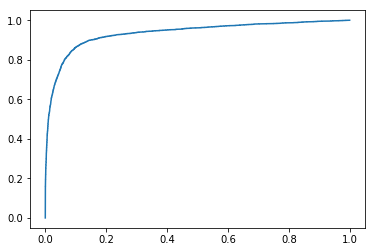

In [62]:
plt.plot(fpr,tpr)